# PGS Pairwise Comparison Pipeline (Memory-Safe)

**Purpose:** Pre-compute pairwise comparisons between polygenic scores (PGS) for the same trait to help researchers decide which PGS to use when multiple options exist.

**Memory-Safe Architecture (v3.0):**
- **Trait-chunked processing**: Process traits in batches of 50, loading only needed PGS per batch
- **On-demand loading**: Parse ~200 PGS files per batch instead of all 5,057 upfront
- **Explicit memory management**: psutil monitoring + gc.collect() between batches
- **Peak memory**: ~15-20GB (vs ~94GB in monolithic approach)

**Other Optimizations:**
- Parallel downloads (16 threads)
- Polars for fast DataFrame operations
- Streaming accumulation of results

**Hardware Requirements:**
- Recommended: 32 cores, 96GB RAM
- Minimum: 8 cores, 32GB RAM (memory-safe design allows lower RAM)

**Expected Runtime:** ~15-25 minutes for full catalog

**Authors:** Phenome Health Bioinformatics Team  
**Date:** February 2026  
**Version:** 3.0 (Memory-Safe)

## Table of Contents

1. [Setup & Configuration](#1-setup--configuration)
2. [Fetch PGS Catalog Metadata](#2-fetch-pgs-catalog-metadata)
3. [Identify Traits with Multiple PGS](#3-identify-traits-with-multiple-pgs)
4. [Download Harmonized Scoring Files (Parallel)](#4-download-harmonized-scoring-files-parallel)
5. [Scoring File Parser & On-Demand Loading](#5-scoring-file-parser--on-demand-loading)
6. [Memory-Safe Chunked Processing](#6-memory-safe-chunked-processing)
7. [Export Static Dataset](#7-export-static-dataset)
8. [Summary & Quality Control](#8-summary--quality-control)
9. [Visualization Examples](#9-visualization-examples)

---
## 1. Setup & Configuration

In [36]:
# Install required packages if needed
# !pip install polars joblib requests tqdm plotly pandas pyarrow

In [37]:
# Core dependencies
import os
import gzip
import json
import time
import requests
import logging
from pathlib import Path
from datetime import datetime
from typing import Optional, Any
from itertools import combinations
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count, Manager

import numpy as np
import pandas as pd
import polars as pl
from joblib import Parallel, delayed
from scipy import stats
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Check available resources
print(f"Available CPU cores: {cpu_count()}")
print(f"Pipeline started: {datetime.now().isoformat()}")

Available CPU cores: 32
Pipeline started: 2026-02-22T15:06:37.688593


In [38]:
# Memory monitoring utilities for memory-safe processing
import psutil
import gc

def get_memory_usage_gb():
    """Return current process memory usage in GB."""
    process = psutil.Process()
    return process.memory_info().rss / (1024**3)

def get_available_memory_gb():
    """Return available system memory in GB."""
    return psutil.virtual_memory().available / (1024**3)

def memory_status():
    """Print memory status and return (used, available) in GB."""
    used = get_memory_usage_gb()
    available = get_available_memory_gb()
    print(f"Memory: {used:.1f}GB used | {available:.1f}GB available")
    return used, available

# Set memory ceiling (leave ~20GB headroom for system)
MEMORY_CEILING_GB = 70  # Stop loading if we exceed this

print("Memory monitoring utilities loaded")
memory_status()

Memory monitoring utilities loaded
Memory: 0.5GB used | 58.2GB available


(0.4745674133300781, 58.15558624267578)

In [39]:
# =============================================================================
# CONFIGURATION - Modify these settings as needed
# =============================================================================

# Paths
DATA_DIR = Path("./pgs_comparison_data")
SCORING_FILES_DIR = DATA_DIR / "scoring_files"
OUTPUT_DIR = DATA_DIR / "output"
CACHE_DIR = DATA_DIR / "cache"

# Create directories
for dir_path in [DATA_DIR, SCORING_FILES_DIR, OUTPUT_DIR, CACHE_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# PGS Catalog API
PGS_CATALOG_API = "https://www.pgscatalog.org/rest"
PGS_CATALOG_FTP = "https://ftp.ebi.ac.uk/pub/databases/spot/pgs/scores"

# Processing settings
CONFIG = {
    # Which genome build to use for harmonized files
    "genome_build": "GRCh38",  # Options: "GRCh37", "GRCh38"
    
    # Quality tier filter (None = all scores, or list like ["gold", "silver"])
    "quality_tiers": None,  # Start with all, can filter later
    
    # Minimum number of PGS per trait to include in pairwise analysis
    "min_pgs_per_trait": 2,
    
    # Maximum variants to store per pair (for plotting)
    # TUNED: Reduced from 50K to 10K - full catalog produces ~158K pairs
    "max_variants_for_plot": 10000,
    
    # === PARALLELIZATION SETTINGS ===
    # Download threads (network I/O bound - can be higher than CPU count)
    "download_threads": 16,
    
    # Parsing workers (CPU bound - match to available cores)
    # NOTE: Sequential parsing is used instead (see cell-16) due to memory constraints
    "parsing_workers": min(32, cpu_count()),
    
    # Pairwise comparison workers
    # TUNED: Reduced from 32 to 4 - prevents OOM during correlation computation
    "comparison_workers": 4,
    
    # Request timeout (seconds)
    "request_timeout": 60,
    
    # Retry settings
    "max_retries": 3,
    "retry_delay": 2,
    
    # === OPTIONAL: LIMIT FOR TESTING ===
    # Set to None for full run, or a number to limit traits processed
    "max_traits": None,  # e.g., 10 for quick test
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  genome_build: GRCh38
  quality_tiers: None
  min_pgs_per_trait: 2
  max_variants_for_plot: 10000
  download_threads: 16
  parsing_workers: 32
  comparison_workers: 4
  request_timeout: 60
  max_retries: 3
  retry_delay: 2
  max_traits: None


In [40]:
# =============================================================================
# CHECKPOINT: Load Pre-computed Results if Available
# =============================================================================
# Loads stats (5MB) and sample variants (~0.5MB) for visualization demos.
# Full variants file (4.6GB → 50-70GB in memory) is NOT loaded.

CHECKPOINT_LOADED = False
comparison_stats = None
shared_variants_dict = None

stats_path = OUTPUT_DIR / "pgs_pairwise_stats.parquet"

# Sample file path - handle both running from project root and from data/ dir
sample_variants_path = Path("pgs_pairwise_variants_sample.json.gz")
if not sample_variants_path.exists():
    sample_variants_path = Path("data/pgs_pairwise_variants_sample.json.gz")

if stats_path.exists():
    print("=" * 60)
    print("CHECKPOINT: Loading pre-computed statistics")
    print("=" * 60)

    mem_before = get_memory_usage_gb()
    comparison_stats = pd.read_parquet(stats_path)
    print(f"✓ Loaded comparison_stats: {len(comparison_stats):,} pairs")

    # Load sample variants for visualization (small subset)
    if sample_variants_path.exists():
        with gzip.open(sample_variants_path, "rt") as f:
            shared_variants_dict = json.load(f)
        print(f"✓ Loaded shared_variants_dict (sample): {len(shared_variants_dict)} pairs")
    else:
        print("⚠ Sample variants not found - run: python scripts/extract_sample_variants.py")

    mem_after = get_memory_usage_gb()
    print(f"  Memory used: {mem_after - mem_before:.2f}GB")

    if (OUTPUT_DIR / "pipeline_metadata.json").exists():
        with open(OUTPUT_DIR / "pipeline_metadata.json") as f:
            cached_metadata = json.load(f)
        print(f"✓ Original run: {cached_metadata.get('generated_at', 'unknown')}")

    CHECKPOINT_LOADED = True
    print("\n" + "=" * 60)
    print("⏩ CHECKPOINT LOADED")
    print("=" * 60)
    if shared_variants_dict:
        print(f"   Scatterplots available for {len(shared_variants_dict)} sample pairs")
    print("   Skip to Section 8 (Summary) or Section 9 (Visualization)")
else:
    print("No cached stats found - run full pipeline")

CHECKPOINT: Loading pre-computed statistics
✓ Loaded comparison_stats: 157,775 pairs
✓ Loaded shared_variants_dict (sample): 50 pairs
  Memory used: 0.01GB
✓ Original run: 2026-02-22T05:42:37.538673

⏩ CHECKPOINT LOADED
   Scatterplots available for 50 sample pairs
   Skip to Section 8 (Summary) or Section 9 (Visualization)


### Hardware Tuning Notes

These settings were tuned for a 32-core / 96GB RAM system after an OOM crash:

| Setting | Original | Tuned | Why |
|---------|----------|-------|-----|
| `comparison_workers` | 32 | 4 | 32 workers × 5K DataFrames caused OOM during correlation computation |
| `parsing_workers` | 32 | 1 (sequential) | Multiprocessing serialization overhead exceeded memory |
| `max_variants_for_plot` | 50,000 | 10,000 | Full catalog produces ~158K pairs; 50K variants/pair = multi-GB output |

**For smaller runs (≤50 traits), the original parallel settings may work fine.**

**What went wrong:**
1. The parsing phase used `multiprocessing.Pool` which pickles/serializes each DataFrame to send to worker processes
2. With 5,057 large scoring files, serialization overhead exceeded available RAM
3. The comparison phase ran 32 parallel correlation computations, each creating intermediate numpy arrays
4. Combined memory from 5K+ DataFrames + 32 concurrent correlations exhausted 94GB RAM

---
## 2. Fetch PGS Catalog Metadata

In [ ]:
def fetch_paginated(endpoint: str, params: dict = None) -> list:
    """
    Fetch all results from a paginated PGS Catalog API endpoint.
    """
    url = f"{PGS_CATALOG_API}{endpoint}"
    all_results = []
    page = 1
    
    with tqdm(desc=f"Fetching {endpoint}", unit="page") as pbar:
        while url:
            for attempt in range(CONFIG["max_retries"]):
                try:
                    response = requests.get(
                        url, 
                        params=params if page == 1 else None,
                        timeout=CONFIG["request_timeout"]
                    )
                    response.raise_for_status()
                    data = response.json()
                    break
                except requests.exceptions.RequestException as e:
                    if attempt < CONFIG["max_retries"] - 1:
                        delay = CONFIG["retry_delay"] * (attempt + 1)
                        time.sleep(delay)
                    else:
                        raise
            
            results = data.get("results", [])
            all_results.extend(results)
            
            url = data.get("next")
            page += 1
            pbar.update(1)
            pbar.set_postfix({"total_results": len(all_results)})
    
    return all_results

In [ ]:
# Check for cached metadata first
metadata_cache_path = CACHE_DIR / "scores_metadata.parquet"

if metadata_cache_path.exists():
    print(f"Loading cached metadata from {metadata_cache_path}")
    scores_df = pd.read_parquet(metadata_cache_path)
    print(f"Loaded {len(scores_df)} scores from cache")
else:
    # Fetch from API
    logger.info("Fetching all scores from PGS Catalog...")
    scores_raw = fetch_paginated("/score/all")
    logger.info(f"Fetched {len(scores_raw)} scores")
    
    # Parse metadata
    def parse_score_metadata(score: dict) -> dict:
        """Extract relevant fields from a PGS Catalog score record."""
        # Extract trait info
        trait_efo = None
        trait_label = None
        if score.get("trait_efo"):
            first_trait = score["trait_efo"][0] if isinstance(score["trait_efo"], list) else score["trait_efo"]
            if isinstance(first_trait, dict):
                trait_efo = first_trait.get("id")
                trait_label = first_trait.get("label")
            elif isinstance(first_trait, str):
                trait_efo = first_trait
        
        # Extract harmonized file availability
        has_grch37 = False
        has_grch38 = False
        ftp_harmonized_files = score.get("ftp_harmonized_scoring_files", {}) or {}
        if ftp_harmonized_files:
            has_grch37 = bool(ftp_harmonized_files.get("GRCh37", {}).get("positions"))
            has_grch38 = bool(ftp_harmonized_files.get("GRCh38", {}).get("positions"))
        
        pub = score.get("publication", {}) or {}
        
        return {
            "pgs_id": score.get("id"),
            "pgs_name": score.get("name"),
            "trait_reported": score.get("trait_reported"),
            "trait_efo": trait_efo,
            "trait_label": trait_label,
            "n_variants": score.get("variants_number"),
            "method_name": score.get("method_name", ""),
            "weight_type": score.get("weight_type", "NR"),
            "has_grch37": has_grch37,
            "has_grch38": has_grch38,
            "ftp_scoring_file": score.get("ftp_scoring_file"),
            "ftp_harmonized_grch37": ftp_harmonized_files.get("GRCh37", {}).get("positions"),
            "ftp_harmonized_grch38": ftp_harmonized_files.get("GRCh38", {}).get("positions"),
            "publication_id": pub.get("id"),
            "publication_date": pub.get("date_publication"),
        }
    
    scores_parsed = [parse_score_metadata(s) for s in scores_raw]
    scores_df = pd.DataFrame(scores_parsed)
    
    # Cache for future runs
    scores_df.to_parquet(metadata_cache_path, index=False)
    print(f"Cached metadata to {metadata_cache_path}")

print(f"\nTotal scores: {len(scores_df)}")
print(f"Scores with GRCh38 harmonized files: {scores_df['has_grch38'].sum()}")
print(f"Unique traits (EFO): {scores_df['trait_efo'].nunique()}")

Loading cached metadata from pgs_comparison_data/cache/scores_metadata.parquet
Loaded 5251 scores from cache

Total scores: 5251
Scores with GRCh38 harmonized files: 5251
Unique traits (EFO): 626


---
## 3. Identify Traits with Multiple PGS

In [ ]:
# Filter to scores with harmonized files for our target build
build = CONFIG["genome_build"]
build_col = f"has_{build.lower()}"

scores_with_harmonized = scores_df[scores_df[build_col] == True].copy()
print(f"Scores with {build} harmonized files: {len(scores_with_harmonized)}")

# Count PGS per trait
trait_counts = scores_with_harmonized.groupby("trait_efo").agg(
    n_pgs=("pgs_id", "count"),
    trait_label=("trait_label", "first"),
    pgs_ids=("pgs_id", list),
    total_variants=("n_variants", "sum"),
).reset_index()

# Filter to traits with multiple PGS
multi_pgs_traits = trait_counts[
    trait_counts["n_pgs"] >= CONFIG["min_pgs_per_trait"]
].copy()

# Calculate number of pairwise comparisons per trait
multi_pgs_traits["n_pairs"] = (
    multi_pgs_traits["n_pgs"] * (multi_pgs_traits["n_pgs"] - 1) // 2
)

# Optional: limit for testing
if CONFIG["max_traits"]:
    multi_pgs_traits = multi_pgs_traits.head(CONFIG["max_traits"])
    print(f"\n⚠️ LIMITED TO {CONFIG['max_traits']} TRAITS FOR TESTING")

print(f"\nTraits with ≥{CONFIG['min_pgs_per_trait']} PGS: {len(multi_pgs_traits)}")
print(f"Total pairwise comparisons needed: {multi_pgs_traits['n_pairs'].sum():,}")

# Get list of all unique PGS IDs we need to download
pgs_ids_to_download = set()
for pgs_list in multi_pgs_traits["pgs_ids"]:
    pgs_ids_to_download.update(pgs_list)

print(f"Unique PGS to download: {len(pgs_ids_to_download)}")

# =============================================================================
# TRAIT BATCHING FOR MEMORY-SAFE PROCESSING
# =============================================================================
# Create mapping: trait_efo -> info needed for processing
trait_to_pgs = {}
for _, row in multi_pgs_traits.iterrows():
    trait_to_pgs[row["trait_efo"]] = {
        "pgs_ids": row["pgs_ids"],
        "trait_label": row["trait_label"],
        "n_pairs": row["n_pairs"],
    }

# Chunk traits into batches for memory-safe processing
# Each batch processes ~50 traits at a time, loading only the PGS needed for that batch
BATCH_SIZE = 50  # Process 50 traits at a time (~9 batches total for 432 traits)
trait_efos = list(trait_to_pgs.keys())
trait_batches = [
    trait_efos[i:i+BATCH_SIZE]
    for i in range(0, len(trait_efos), BATCH_SIZE)
]

print(f"\n--- Memory-Safe Batching ---")
print(f"BATCH_SIZE: {BATCH_SIZE} traits per batch")
print(f"Split {len(trait_to_pgs)} traits into {len(trait_batches)} batches")
print(f"Expected peak memory: ~15-20GB (vs ~94GB without batching)")

Scores with GRCh38 harmonized files: 5251

Traits with ≥2 PGS: 432
Total pairwise comparisons needed: 158,231
Unique PGS to download: 5057

--- Memory-Safe Batching ---
BATCH_SIZE: 50 traits per batch
Split 432 traits into 9 batches
Expected peak memory: ~15-20GB (vs ~94GB without batching)


---
## 4. Download Harmonized Scoring Files (Parallel)

Using 16 parallel download threads for network I/O.

In [ ]:
def get_scoring_file_url(pgs_id: str, build: str = "GRCh38") -> str:
    """Construct the FTP URL for a harmonized scoring file."""
    return (
        f"{PGS_CATALOG_FTP}/{pgs_id}/ScoringFiles/Harmonized/"
        f"{pgs_id}_hmPOS_{build}.txt.gz"
    )


def download_scoring_file(
    pgs_id: str, 
    build: str = "GRCh38",
    output_dir: Path = SCORING_FILES_DIR,
) -> tuple[str, Optional[Path]]:
    """
    Download a harmonized scoring file if not already cached.
    Returns tuple of (pgs_id, path_or_none).
    """
    output_path = output_dir / f"{pgs_id}_hmPOS_{build}.txt.gz"
    
    # Check cache
    if output_path.exists() and output_path.stat().st_size > 0:
        return (pgs_id, output_path)
    
    url = get_scoring_file_url(pgs_id, build)
    
    for attempt in range(CONFIG["max_retries"]):
        try:
            response = requests.get(url, timeout=CONFIG["request_timeout"], stream=True)
            response.raise_for_status()
            
            with open(output_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=65536):
                    f.write(chunk)
            
            return (pgs_id, output_path)
            
        except requests.exceptions.RequestException as e:
            if attempt < CONFIG["max_retries"] - 1:
                time.sleep(CONFIG["retry_delay"] * (attempt + 1))
            else:
                return (pgs_id, None)
    
    return (pgs_id, None)

In [ ]:
# Download all scoring files in parallel
build = CONFIG["genome_build"]
download_results = {}

logger.info(f"Downloading {len(pgs_ids_to_download)} scoring files with {CONFIG['download_threads']} threads...")
start_time = time.time()

with ThreadPoolExecutor(max_workers=CONFIG["download_threads"]) as executor:
    futures = {
        executor.submit(download_scoring_file, pgs_id, build, SCORING_FILES_DIR): pgs_id
        for pgs_id in pgs_ids_to_download
    }
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
        try:
            pgs_id, result_path = future.result()
            download_results[pgs_id] = result_path
        except Exception as e:
            pgs_id = futures[future]
            logger.error(f"Error downloading {pgs_id}: {e}")
            download_results[pgs_id] = None

elapsed = time.time() - start_time
successful = sum(1 for v in download_results.values() if v is not None)
failed = sum(1 for v in download_results.values() if v is None)

print(f"\nDownload complete in {elapsed:.1f}s")
print(f"  Successful: {successful}")
print(f"  Failed: {failed}")
print(f"  Rate: {successful / elapsed:.1f} files/sec")

2026-02-22 03:34:25,974 - INFO - Downloading 5057 scoring files with 16 threads...
Downloading: 100%|██████████| 5057/5057 [00:00<00:00, 48886.87it/s]


Download complete in 0.2s
  Successful: 5057
  Failed: 0
  Rate: 31620.2 files/sec


---
## 5. Scoring File Parser & On-Demand Loading

Instead of parsing all 5,057 files upfront (which consumed ~94GB RAM), we define a parser function
and load files on-demand per trait batch. This reduces peak memory from ~94GB to ~3-5GB per batch.

In [ ]:
def parse_scoring_file_to_polars(file_path: Path) -> Optional[pl.DataFrame]:
    """
    Parse a PGS Catalog scoring file into a Polars DataFrame.
    Polars is significantly faster than pandas for this workload.
    
    Key fixes applied:
    - Uses infer_schema_length=0 to avoid type errors on chr X (read all as strings)
    - Handles duplicate column names (hm_rsID vs rsID, hm_chr vs chr_name) by 
      selecting preferred columns directly instead of renaming
    """
    try:
        # Count header lines
        with gzip.open(file_path, "rt") as f:
            header_lines = 0
            for line in f:
                if line.startswith("#"):
                    header_lines += 1
                else:
                    break
        
        # Read with Polars - use infer_schema_length=0 to read all as strings
        # This prevents type inference errors when chr column contains "X", "Y"
        df = pl.read_csv(
            file_path,
            separator="\t",
            skip_rows=header_lines,
            infer_schema_length=0,  # Read all as strings to avoid type errors
            null_values=["NA", "", "."],
        )
        
        # Identify preferred columns (prefer harmonized columns)
        rsid_col = "hm_rsID" if "hm_rsID" in df.columns else ("rsID" if "rsID" in df.columns else None)
        chr_col = "hm_chr" if "hm_chr" in df.columns else ("chr_name" if "chr_name" in df.columns else None)
        pos_col = "hm_pos" if "hm_pos" in df.columns else ("chr_position" if "chr_position" in df.columns else None)
        
        # Check for required weight column
        if "effect_weight" not in df.columns:
            logger.warning(f"No 'effect_weight' column in {file_path}")
            return None
        
        # Cast weight to float
        df = df.with_columns(pl.col("effect_weight").cast(pl.Float64, strict=False).alias("weight"))
        df = df.drop_nulls(subset=["weight"])
        
        if len(df) == 0:
            return None
        
        # Create variant_id for matching
        if rsid_col and rsid_col in df.columns:
            # Use rsid where available, fall back to chr:pos
            if chr_col and pos_col and chr_col in df.columns and pos_col in df.columns:
                df = df.with_columns(
                    pl.when(pl.col(rsid_col).is_not_null() & (pl.col(rsid_col) != ""))
                    .then(pl.col(rsid_col))
                    .otherwise(
                        pl.col(chr_col).cast(pl.Utf8) + ":" + pl.col(pos_col).cast(pl.Utf8)
                    )
                    .alias("variant_id")
                )
            else:
                df = df.with_columns(pl.col(rsid_col).alias("variant_id"))
        elif chr_col and pos_col and chr_col in df.columns and pos_col in df.columns:
            df = df.with_columns(
                (pl.col(chr_col).cast(pl.Utf8) + ":" + pl.col(pos_col).cast(pl.Utf8)).alias("variant_id")
            )
        else:
            # No usable identifiers
            logger.warning(f"No variant identifiers found in {file_path}")
            return None
        
        # Keep only needed columns
        keep_cols = ["variant_id", "weight"]
        if "effect_allele" in df.columns:
            keep_cols.append("effect_allele")
        
        df = df.select([c for c in keep_cols if c in df.columns])
        
        return df
        
    except Exception as e:
        logger.error(f"Error parsing {file_path}: {e}")
        return None


def parse_wrapper(args: tuple) -> tuple[str, Optional[pl.DataFrame]]:
    """Wrapper for multiprocessing (kept for compatibility but not used)."""
    pgs_id, file_path = args
    if file_path is None:
        return (pgs_id, None)
    df = parse_scoring_file_to_polars(file_path)
    return (pgs_id, df)

In [ ]:
# =============================================================================
# ON-DEMAND LOADING FUNCTION
# =============================================================================
# Instead of parsing all 5,057 files upfront (which consumes ~94GB RAM),
# we load only the PGS files needed for each batch of traits.
# This reduces peak memory from ~94GB to ~3-5GB per batch.

def load_pgs_subset(pgs_ids: set, download_results: dict) -> dict:
    """
    Parse only the PGS files needed for a specific batch.
    
    Args:
        pgs_ids: Set of PGS IDs to load
        download_results: Dict mapping PGS ID -> file path
    
    Returns:
        Dict mapping PGS ID -> Polars DataFrame
    """
    subset = {}
    for pgs_id in pgs_ids:
        path = download_results.get(pgs_id)
        if path is not None:
            df = parse_scoring_file_to_polars(path)
            if df is not None:
                subset[pgs_id] = df
    return subset

# Don't parse everything upfront - we'll load on-demand per trait batch
logger.info("Skipping bulk parsing - will load on-demand per trait batch")
logger.info(f"This saves ~90GB RAM by loading only ~200 PGS per batch instead of all 5,057")
print(f"\n✓ On-demand loading function ready")
print(f"  Will parse files as needed during batch processing")
memory_status()

2026-02-22 03:34:26,169 - INFO - Skipping bulk parsing - will load on-demand per trait batch
2026-02-22 03:34:26,170 - INFO - This saves ~90GB RAM by loading only ~200 PGS per batch instead of all 5,057



✓ On-demand loading function ready
  Will parse files as needed during batch processing
Memory: 0.3GB used | 71.6GB available


(0.28716278076171875, 71.55469512939453)

---
## 6. Memory-Safe Chunked Processing

Process traits in batches, loading only the ~200 PGS files needed for each batch.
This approach:
1. Loads only the PGS files needed for the current batch (~200 vs 5,057)
2. Computes pairwise comparisons for all traits in the batch
3. Accumulates results incrementally
4. Explicitly releases batch memory with gc.collect()
5. Monitors memory usage and aborts if ceiling is exceeded

In [ ]:
def compute_pairwise_comparison_polars(
    pgs_id_1: str,
    pgs_id_2: str,
    df1: pl.DataFrame,
    df2: pl.DataFrame,
    max_variants_for_plot: int = 50000
) -> Optional[dict]:
    """
    Compute comparison statistics between two PGS using Polars.
    """
    n_1 = len(df1)
    n_2 = len(df2)
    
    # Inner join on variant_id
    joined = df1.select(["variant_id", "weight"]).join(
        df2.select(["variant_id", "weight"]),
        on="variant_id",
        how="inner",
        suffix="_2"
    )
    
    n_shared = len(joined)
    
    # Handle no overlap case
    if n_shared == 0:
        return {
            "pgs_id_1": pgs_id_1,
            "pgs_id_2": pgs_id_2,
            "n_variants_1": n_1,
            "n_variants_2": n_2,
            "n_shared": 0,
            "pct_overlap_1": 0.0,
            "pct_overlap_2": 0.0,
            "pearson_r": None,
            "pearson_p": None,
            "pct_concordant_sign": None,
            "shared_variants": [],
            "n_sampled": 0,
        }
    
    # Extract numpy arrays for computation
    w1 = joined["weight"].to_numpy()
    w2 = joined["weight_2"].to_numpy()
    
    # Compute correlation
    if n_shared >= 2:
        pearson_r, pearson_p = stats.pearsonr(w1, w2)
    else:
        pearson_r, pearson_p = None, None
    
    # Compute sign concordance
    pct_concordant = float(np.mean(np.sign(w1) == np.sign(w2)) * 100)
    
    # Sample for plotting if needed
    if n_shared > max_variants_for_plot:
        sample_idx = np.random.choice(n_shared, max_variants_for_plot, replace=False)
        sampled = joined[sample_idx.tolist()]
    else:
        sampled = joined
    
    # Convert to list of dicts for JSON serialization
    shared_variants = [
        {
            "variant_id": row["variant_id"],
            "weight_1": float(row["weight"]),
            "weight_2": float(row["weight_2"]),
        }
        for row in sampled.iter_rows(named=True)
    ]
    
    return {
        "pgs_id_1": pgs_id_1,
        "pgs_id_2": pgs_id_2,
        "n_variants_1": n_1,
        "n_variants_2": n_2,
        "n_shared": n_shared,
        "pct_overlap_1": (n_shared / n_1) * 100 if n_1 > 0 else 0,
        "pct_overlap_2": (n_shared / n_2) * 100 if n_2 > 0 else 0,
        "pearson_r": float(pearson_r) if pearson_r is not None else None,
        "pearson_p": float(pearson_p) if pearson_p is not None else None,
        "pct_concordant_sign": pct_concordant,
        "shared_variants": shared_variants,
        "n_sampled": len(shared_variants),
    }

In [ ]:
# Helper function kept for reference - now called directly in batch loop
def process_trait_batch_comparisons(
    trait_efo: str,
    trait_info: dict,
    batch_parsed: dict,
    max_variants: int
) -> list[dict]:
    """
    Process all pairwise comparisons for a single trait using pre-loaded batch data.
    """
    available_pgs = [p for p in trait_info["pgs_ids"] if p in batch_parsed]
    
    if len(available_pgs) < 2:
        return []
    
    results = []
    
    for pgs_1, pgs_2 in combinations(available_pgs, 2):
        df1 = batch_parsed[pgs_1]
        df2 = batch_parsed[pgs_2]
        
        result = compute_pairwise_comparison_polars(
            pgs_1, pgs_2, df1, df2, max_variants
        )
        
        if result:
            result["trait_efo"] = trait_efo
            result["trait_label"] = trait_info["trait_label"]
            results.append(result)
    
    return results

In [ ]:
# =============================================================================
# MEMORY-SAFE CHUNKED PROCESSING LOOP
# =============================================================================
# Process traits in batches, loading only the PGS needed for each batch.
# This reduces peak memory from ~94GB to ~15-20GB.

# Output paths
stats_output_path = OUTPUT_DIR / "pgs_pairwise_stats.parquet"
variants_output_path = OUTPUT_DIR / "pgs_pairwise_variants.json.gz"

# Accumulators
all_stats_rows = []
shared_variants_dict = {}
total_pgs_parsed = set()  # Track unique PGS parsed across all batches

logger.info(f"Processing {len(trait_batches)} batches of ~{BATCH_SIZE} traits each...")
logger.info(f"Memory ceiling: {MEMORY_CEILING_GB}GB")
pipeline_start_time = time.time()

for batch_idx, trait_efo_batch in enumerate(tqdm(trait_batches, desc="Trait batches")):
    batch_start = time.time()
    
    print(f"\n{'='*60}")
    print(f"BATCH {batch_idx + 1}/{len(trait_batches)}")
    print(f"{'='*60}")
    used_gb, available_gb = memory_status()
    
    # 1. Identify all PGS needed for this batch
    batch_pgs_ids = set()
    for trait_efo in trait_efo_batch:
        batch_pgs_ids.update(trait_to_pgs[trait_efo]["pgs_ids"])
    
    logger.info(f"Batch {batch_idx+1}: {len(trait_efo_batch)} traits, {len(batch_pgs_ids)} unique PGS to load")
    
    # 2. Parse only the needed files for this batch
    parse_start = time.time()
    batch_parsed = load_pgs_subset(batch_pgs_ids, download_results)
    parse_elapsed = time.time() - parse_start
    logger.info(f"  Parsed {len(batch_parsed)} files in {parse_elapsed:.1f}s")
    total_pgs_parsed.update(batch_parsed.keys())
    
    # 3. Memory safety check after parsing
    used_gb, available_gb = memory_status()
    if used_gb > MEMORY_CEILING_GB:
        logger.warning(f"Memory ceiling ({MEMORY_CEILING_GB}GB) exceeded! Forcing GC...")
        gc.collect()
        used_gb, _ = memory_status()
        if used_gb > MEMORY_CEILING_GB:
            raise MemoryError(f"Cannot proceed - memory at {used_gb:.1f}GB after GC")
    
    # 4. Compute comparisons for all traits in this batch
    batch_results = []
    for trait_efo in trait_efo_batch:
        trait_info = trait_to_pgs[trait_efo]
        trait_results = process_trait_batch_comparisons(
            trait_efo, trait_info, batch_parsed, CONFIG["max_variants_for_plot"]
        )
        batch_results.extend(trait_results)
    
    logger.info(f"  Computed {len(batch_results)} pairwise comparisons")
    
    # 5. Accumulate stats and shared variants
    for r in batch_results:
        # Stats without shared_variants (save memory)
        all_stats_rows.append({k: v for k, v in r.items() if k != "shared_variants"})
        # Shared variants for plotting
        pair_key = f"{r['pgs_id_1']}_{r['pgs_id_2']}"
        shared_variants_dict[pair_key] = r["shared_variants"]
    
    # 6. Clear batch memory explicitly
    del batch_parsed
    del batch_results
    gc.collect()
    
    batch_elapsed = time.time() - batch_start
    print(f"Batch {batch_idx+1} complete: {batch_elapsed:.1f}s | {len(all_stats_rows)} pairs total")
    memory_status()

pipeline_elapsed = time.time() - pipeline_start_time
print(f"\n{'='*60}")
print(f"PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Total time: {pipeline_elapsed:.1f}s ({pipeline_elapsed/60:.1f} minutes)")
print(f"Total pairs computed: {len(all_stats_rows):,}")
print(f"Unique PGS parsed: {len(total_pgs_parsed)}")
memory_status()

2026-02-22 03:34:26,248 - INFO - Processing 9 batches of ~50 traits each...
2026-02-22 03:34:26,249 - INFO - Memory ceiling: 70GB
Trait batches:   0%|          | 0/9 [00:00<?, ?it/s]2026-02-22 03:34:26,252 - INFO - Batch 1: 50 traits, 759 unique PGS to load



BATCH 1/9
Memory: 0.3GB used | 71.6GB available


2026-02-22 03:34:28,418 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004299_hmPOS_GRCh38.txt.gz
2026-02-22 03:34:35,477 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004262_hmPOS_GRCh38.txt.gz
2026-02-22 03:34:52,584 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004263_hmPOS_GRCh38.txt.gz
2026-02-22 03:35:12,950 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004264_hmPOS_GRCh38.txt.gz
2026-02-22 03:35:15,531 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004261_hmPOS_GRCh38.txt.gz
2026-02-22 03:35:17,485 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004256_hmPOS_GRCh38.txt.gz
2026-02-22 03:35:34,021 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004259_hmPOS_GRCh38.txt.gz
2026-02-22 03:35:34,022 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_file

Memory: 24.7GB used | 64.0GB available


/tmp/ipykernel_233552/3317443384.py:47: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(w1, w2)
2026-02-22 03:43:52,227 - INFO -   Computed 19910 pairwise comparisons
Trait batches:  11%|█         | 1/9 [09:26<1:15:35, 566.96s/it]2026-02-22 03:43:53,215 - INFO - Batch 2: 50 traits, 464 unique PGS to load


Batch 1 complete: 567.0s | 19910 pairs total
Memory: 34.5GB used | 62.1GB available

BATCH 2/9
Memory: 34.5GB used | 62.1GB available


2026-02-22 03:44:35,871 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004272_hmPOS_GRCh38.txt.gz
2026-02-22 03:44:43,461 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004273_hmPOS_GRCh38.txt.gz
2026-02-22 03:44:44,299 - INFO -   Parsed 462 files in 51.1s


Memory: 34.8GB used | 61.9GB available


2026-02-22 03:47:36,407 - INFO -   Computed 6798 pairwise comparisons
Trait batches:  22%|██▏       | 2/9 [13:10<42:36, 365.21s/it]  2026-02-22 03:47:37,193 - INFO - Batch 3: 50 traits, 1347 unique PGS to load


Batch 2 complete: 224.0s | 26708 pairs total
Memory: 37.7GB used | 58.3GB available

BATCH 3/9
Memory: 37.7GB used | 58.3GB available


2026-02-22 03:50:27,757 - INFO -   Parsed 1347 files in 170.6s


Memory: 54.5GB used | 56.6GB available


2026-02-22 04:14:48,878 - INFO -   Computed 85072 pairwise comparisons
Trait batches:  33%|███▎      | 3/9 [40:25<1:34:30, 945.04s/it]2026-02-22 04:14:52,234 - INFO - Batch 4: 50 traits, 520 unique PGS to load


Batch 3 complete: 1635.0s | 111780 pairs total
Memory: 69.6GB used | 44.0GB available

BATCH 4/9
Memory: 69.6GB used | 44.0GB available


2026-02-22 04:16:11,232 - INFO -   Parsed 520 files in 79.0s


Memory: 51.4GB used | 41.5GB available


2026-02-22 04:22:03,367 - INFO -   Computed 7102 pairwise comparisons
Trait batches:  44%|████▍     | 4/9 [47:38<1:01:54, 742.88s/it]2026-02-22 04:22:05,206 - INFO - Batch 5: 50 traits, 346 unique PGS to load


Batch 4 complete: 433.0s | 118882 pairs total
Memory: 59.9GB used | 38.0GB available

BATCH 5/9
Memory: 59.9GB used | 38.0GB available


2026-02-22 04:22:37,927 - INFO -   Parsed 346 files in 32.7s


Memory: 51.5GB used | 37.9GB available


2026-02-22 04:23:29,735 - INFO -   Computed 1902 pairwise comparisons
Trait batches:  56%|█████▌    | 5/9 [49:05<33:44, 506.17s/it]  2026-02-22 04:23:31,675 - INFO - Batch 6: 50 traits, 201 unique PGS to load


Batch 5 complete: 86.5s | 120784 pairs total
Memory: 53.8GB used | 36.2GB available

BATCH 6/9
Memory: 53.8GB used | 36.2GB available


2026-02-22 04:23:46,495 - INFO -   Parsed 201 files in 14.8s


Memory: 51.0GB used | 37.1GB available


2026-02-22 04:24:06,227 - INFO -   Computed 442 pairwise comparisons
Trait batches:  67%|██████▋   | 6/9 [49:41<17:18, 346.31s/it]2026-02-22 04:24:07,654 - INFO - Batch 7: 50 traits, 222 unique PGS to load


Batch 6 complete: 36.0s | 121226 pairs total
Memory: 51.2GB used | 36.5GB available

BATCH 7/9
Memory: 51.2GB used | 36.5GB available


2026-02-22 04:24:17,178 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004301_hmPOS_GRCh38.txt.gz
2026-02-22 04:24:26,702 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004304_hmPOS_GRCh38.txt.gz
2026-02-22 04:24:30,133 - WARNING - No 'effect_weight' column in pgs_comparison_data/scoring_files/PGS004280_hmPOS_GRCh38.txt.gz
2026-02-22 04:24:30,134 - INFO -   Parsed 219 files in 22.5s


Memory: 51.7GB used | 37.5GB available


2026-02-22 04:25:13,934 - INFO -   Computed 799 pairwise comparisons
Trait batches:  78%|███████▊  | 7/9 [50:49<08:30, 255.23s/it]2026-02-22 04:25:15,376 - INFO - Batch 8: 50 traits, 774 unique PGS to load


Batch 7 complete: 67.7s | 122025 pairs total
Memory: 52.9GB used | 36.8GB available

BATCH 8/9
Memory: 52.9GB used | 36.8GB available


2026-02-22 04:26:34,492 - INFO -   Parsed 774 files in 79.1s


Memory: 46.9GB used | 45.5GB available


2026-02-22 04:37:16,074 - INFO -   Computed 25990 pairwise comparisons
Trait batches:  89%|████████▉ | 8/9 [1:03:14<06:51, 411.31s/it]2026-02-22 04:37:40,885 - INFO - Batch 9: 32 traits, 424 unique PGS to load


Batch 8 complete: 745.5s | 148015 pairs total
Memory: 63.4GB used | 37.6GB available

BATCH 9/9
Memory: 63.4GB used | 37.6GB available


2026-02-22 04:38:16,836 - INFO -   Parsed 424 files in 36.0s


Memory: 63.2GB used | 39.4GB available


2026-02-22 04:48:02,018 - INFO -   Computed 9760 pairwise comparisons
Trait batches: 100%|██████████| 9/9 [1:13:39<00:00, 491.08s/it]

Batch 9 complete: 625.1s | 157775 pairs total
Memory: 70.6GB used | 23.2GB available

PROCESSING COMPLETE
Total time: 4419.7s (73.7 minutes)
Total pairs computed: 157,775
Unique PGS parsed: 5042
Memory: 70.6GB used | 23.2GB available


(70.61222076416016, 23.23644256591797)

In [ ]:
# Convert accumulated rows to DataFrame for analysis and export
comparison_stats = pd.DataFrame(all_stats_rows)

print(f"Comparison statistics shape: {comparison_stats.shape}")
print(f"Columns: {list(comparison_stats.columns)}")
comparison_stats.head(10)

Comparison statistics shape: (157775, 13)
Columns: ['pgs_id_1', 'pgs_id_2', 'n_variants_1', 'n_variants_2', 'n_shared', 'pct_overlap_1', 'pct_overlap_2', 'pearson_r', 'pearson_p', 'pct_concordant_sign', 'n_sampled', 'trait_efo', 'trait_label']


,pgs_id_1,pgs_id_2,n_variants_1,n_variants_2,n_shared,pct_overlap_1,pct_overlap_2,pearson_r,pearson_p,pct_concordant_sign,n_sampled,trait_efo,trait_label
0,PGS000646,PGS000647,32,32,32,100.000,100.000000,1.000000,7.444136e-232,100.0,32,EFO_0000095,chronic lymphocytic leukemia
1,PGS000646,PGS000648,32,44,32,100.000,72.727273,1.000000,7.444136e-232,100.0,32,EFO_0000095,chronic lymphocytic leukemia
2,PGS000646,PGS000649,32,27,27,84.375,100.000000,1.000000,0.000000e+00,100.0,27,EFO_0000095,chronic lymphocytic leukemia
3,PGS000646,PGS000650,32,6,1,3.125,16.666667,NaN,NaN,100.0,1,EFO_0000095,chronic lymphocytic leukemia
4,PGS000646,PGS000651,32,76,3,9.375,3.947368,0.943265,2.154749e-01,100.0,3,EFO_0000095,chronic lymphocytic leukemia
5,PGS000646,PGS000874,32,41,0,0.000,0.000000,NaN,NaN,NaN,0,EFO_0000095,chronic lymphocytic leukemia
6,PGS000646,PGS003453,32,43,0,0.000,0.000000,NaN,NaN,NaN,0,EFO_0000095,chronic lymphocytic leukemia
7,PGS000647,PGS000648,32,44,32,100.000,72.727273,1.000000,7.444136e-232,100.0,32,EFO_0000095,chronic lymphocytic leukemia
8,PGS000647,PGS000649,32,27,27,84.375,100.000000,1.000000,0.000000e+00,100.0,27,EFO_0000095,chronic lymphocytic leukemia
9,PGS000647,PGS000650,32,6,1,3.125,16.666667,NaN,NaN,100.0,1,EFO_0000095,chronic lymphocytic leukemia


---
## 7. Export Static Dataset

In [ ]:
# Export summary statistics (parquet for efficient loading)
stats_output_path = OUTPUT_DIR / "pgs_pairwise_stats.parquet"
comparison_stats.to_parquet(stats_output_path, index=False)
print(f"Saved comparison stats: {stats_output_path}")
print(f"  Size: {stats_output_path.stat().st_size / 1e6:.1f} MB")

Saved comparison stats: pgs_comparison_data/output/pgs_pairwise_stats.parquet
  Size: 5.0 MB


In [ ]:
# Export shared variant data for plotting (gzipped JSON)
# Note: shared_variants_dict was already built during batch processing

variants_output_path = OUTPUT_DIR / "pgs_pairwise_variants.json.gz"

with gzip.open(variants_output_path, "wt", encoding="utf-8") as f:
    json.dump(shared_variants_dict, f)

print(f"Saved shared variants: {variants_output_path}")
print(f"  Size: {variants_output_path.stat().st_size / 1e6:.1f} MB")
print(f"  Total pairs with variant data: {len(shared_variants_dict):,}")

Saved shared variants: pgs_comparison_data/output/pgs_pairwise_variants.json.gz
  Size: 4658.8 MB
  Total pairs with variant data: 157,775


In [ ]:
# Export trait lookup table
trait_pairs_lookup = (
    comparison_stats
    .groupby("trait_efo")
    .apply(
        lambda g: g[["pgs_id_1", "pgs_id_2", "pearson_r", "n_shared", 
                     "pct_overlap_1", "pct_overlap_2", "trait_label"]].to_dict("records"),
        include_groups=False
    )
    .to_dict()
)

lookup_output_path = OUTPUT_DIR / "trait_pairs_lookup.json"
with open(lookup_output_path, "w") as f:
    json.dump(trait_pairs_lookup, f, indent=2, default=str)

print(f"Saved trait lookup: {lookup_output_path}")

Saved trait lookup: pgs_comparison_data/output/trait_pairs_lookup.json


In [ ]:
# Export pipeline metadata
pipeline_metadata = {
    "generated_at": datetime.now().isoformat(),
    "genome_build": CONFIG["genome_build"],
    "total_scores_analyzed": len(total_pgs_parsed),  # Use tracked set instead of parsed_scores dict
    "total_traits": comparison_stats["trait_efo"].nunique(),
    "total_pairs": len(comparison_stats),
    "config": {k: str(v) for k, v in CONFIG.items()},
    "runtime_stats": {
        "cpu_cores_used": CONFIG["comparison_workers"],
        "download_threads": CONFIG["download_threads"],
        "batch_size": BATCH_SIZE,
        "num_batches": len(trait_batches),
        "memory_ceiling_gb": MEMORY_CEILING_GB,
    }
}

metadata_output_path = OUTPUT_DIR / "pipeline_metadata.json"
with open(metadata_output_path, "w") as f:
    json.dump(pipeline_metadata, f, indent=2)

print(f"Saved pipeline metadata: {metadata_output_path}")

Saved pipeline metadata: pgs_comparison_data/output/pipeline_metadata.json


---
## 8. Summary & Quality Control

In [41]:
print("=" * 70)
print("PIPELINE SUMMARY")
print("=" * 70)
print(f"Total pairs analyzed: {len(comparison_stats):,}")
print(f"Unique traits: {comparison_stats['trait_efo'].nunique()}")

# Handle checkpoint mode (total_pgs_parsed only exists after full run)
if 'total_pgs_parsed' in dir():
    print(f"Unique PGS: {len(total_pgs_parsed)}")
else:
    unique_pgs = set(comparison_stats['pgs_id_1'].unique()) | set(comparison_stats['pgs_id_2'].unique())
    print(f"Unique PGS: {len(unique_pgs)}")

print()
print("Overlap statistics:")
print(f"  Mean shared variants: {comparison_stats['n_shared'].mean():,.0f}")
print(f"  Median shared variants: {comparison_stats['n_shared'].median():,.0f}")
print(f"  Max shared variants: {comparison_stats['n_shared'].max():,}")
print(f"  Pairs with 0 overlap: {(comparison_stats['n_shared'] == 0).sum()}")
print()
print("Correlation statistics (for pairs with ≥2 shared variants):")
valid_r = comparison_stats["pearson_r"].dropna()
print(f"  Mean Pearson r: {valid_r.mean():.3f}")
print(f"  Median Pearson r: {valid_r.median():.3f}")
print(f"  Std Pearson r: {valid_r.std():.3f}")
print(f"  Highly correlated (r > 0.9): {(valid_r > 0.9).sum()} pairs")
print(f"  Moderately correlated (0.5 < r ≤ 0.9): {((valid_r > 0.5) & (valid_r <= 0.9)).sum()} pairs")
print(f"  Weakly correlated (0 < r ≤ 0.5): {((valid_r > 0) & (valid_r <= 0.5)).sum()} pairs")
print(f"  Negatively correlated (r < 0): {(valid_r < 0).sum()} pairs")

PIPELINE SUMMARY
Total pairs analyzed: 157,775
Unique traits: 432
Unique PGS: 5042

Overlap statistics:
  Mean shared variants: 85,236
  Median shared variants: 29
  Max shared variants: 10,317,475
  Pairs with 0 overlap: 28301

Correlation statistics (for pairs with ≥2 shared variants):
  Mean Pearson r: 0.146
  Median Pearson r: 0.155
  Std Pearson r: 0.504
  Highly correlated (r > 0.9): 6461 pairs
  Moderately correlated (0.5 < r ≤ 0.9): 28406 pairs
  Weakly correlated (0 < r ≤ 0.5): 46141 pairs
  Negatively correlated (r < 0): 43806 pairs


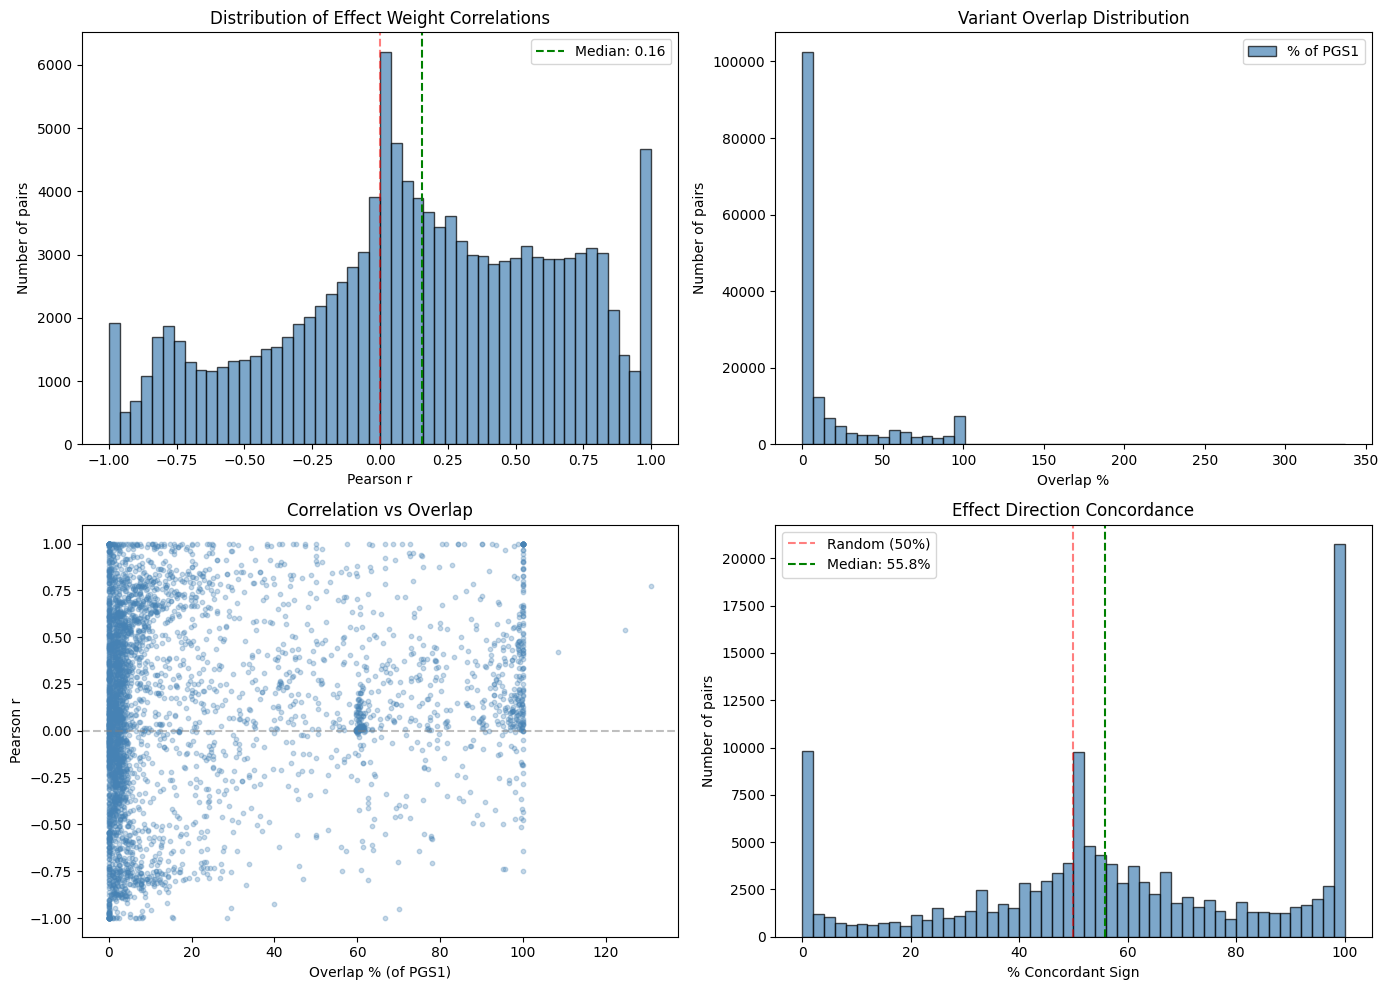

In [42]:
# QC Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Correlation distribution
valid_r = comparison_stats["pearson_r"].dropna()
axes[0, 0].hist(valid_r, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
axes[0, 0].axvline(0, color="red", linestyle="--", alpha=0.5)
axes[0, 0].axvline(valid_r.median(), color="green", linestyle="--", 
                   label=f"Median: {valid_r.median():.2f}")
axes[0, 0].set_xlabel("Pearson r")
axes[0, 0].set_ylabel("Number of pairs")
axes[0, 0].set_title("Distribution of Effect Weight Correlations")
axes[0, 0].legend()

# Overlap percentage distribution
axes[0, 1].hist(comparison_stats["pct_overlap_1"], bins=50, edgecolor="black", 
                alpha=0.7, label="% of PGS1", color="steelblue")
axes[0, 1].set_xlabel("Overlap %")
axes[0, 1].set_ylabel("Number of pairs")
axes[0, 1].set_title("Variant Overlap Distribution")
axes[0, 1].legend()

# Correlation vs overlap scatter
sample_for_plot = comparison_stats.sample(min(5000, len(comparison_stats)))
axes[1, 0].scatter(
    sample_for_plot["pct_overlap_1"],
    sample_for_plot["pearson_r"],
    alpha=0.3,
    s=10,
    c="steelblue"
)
axes[1, 0].set_xlabel("Overlap % (of PGS1)")
axes[1, 0].set_ylabel("Pearson r")
axes[1, 0].set_title("Correlation vs Overlap")
axes[1, 0].axhline(0, color="gray", linestyle="--", alpha=0.5)

# Sign concordance distribution
valid_concordance = comparison_stats["pct_concordant_sign"].dropna()
axes[1, 1].hist(valid_concordance, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
axes[1, 1].axvline(50, color="red", linestyle="--", alpha=0.5, label="Random (50%)")
axes[1, 1].axvline(valid_concordance.median(), color="green", linestyle="--",
                   label=f"Median: {valid_concordance.median():.1f}%")
axes[1, 1].set_xlabel("% Concordant Sign")
axes[1, 1].set_ylabel("Number of pairs")
axes[1, 1].set_title("Effect Direction Concordance")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "qc_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

In [43]:
# Flag potentially problematic pairs
print("=" * 70)
print("QUALITY CONTROL FLAGS")
print("=" * 70)

# Highly correlated pairs (potentially redundant)
redundant = comparison_stats[comparison_stats["pearson_r"] > 0.95]
print(f"\n🔴 Highly correlated pairs (r > 0.95): {len(redundant)}")
if len(redundant) > 0:
    print("   Top 10 potentially redundant pairs:")
    for _, row in redundant.nlargest(10, "pearson_r").iterrows():
        print(f"   - {row['pgs_id_1']} vs {row['pgs_id_2']}: r={row['pearson_r']:.3f} ({row['trait_label']})")

# Negatively correlated pairs
negative = comparison_stats[comparison_stats["pearson_r"] < -0.1]
print(f"\n🟡 Negatively correlated pairs (r < -0.1): {len(negative)}")
if len(negative) > 0:
    print("   May indicate effect allele coding issues:")
    for _, row in negative.nsmallest(10, "pearson_r").iterrows():
        print(f"   - {row['pgs_id_1']} vs {row['pgs_id_2']}: r={row['pearson_r']:.3f} ({row['trait_label']})")

# Very low concordance
low_concordance = comparison_stats[
    (comparison_stats["pct_concordant_sign"] < 40) & 
    (comparison_stats["n_shared"] >= 100)
]
print(f"\n🟡 Low sign concordance (<40%, ≥100 shared): {len(low_concordance)}")

# Zero overlap
no_overlap = comparison_stats[comparison_stats["n_shared"] == 0]
print(f"\n⚪ No variant overlap: {len(no_overlap)} pairs")

QUALITY CONTROL FLAGS

🔴 Highly correlated pairs (r > 0.95): 4971
   Top 10 potentially redundant pairs:
   - PGS000646 vs PGS000649: r=1.000 (chronic lymphocytic leukemia)
   - PGS000647 vs PGS000649: r=1.000 (chronic lymphocytic leukemia)
   - PGS000648 vs PGS000649: r=1.000 (chronic lymphocytic leukemia)
   - PGS000638 vs PGS000639: r=1.000 (Hodgkins lymphoma)
   - PGS001773 vs PGS002755: r=1.000 (atopic eczema)
   - PGS003459 vs PGS003486: r=1.000 (atopic eczema)
   - PGS001340 vs PGS004290: r=1.000 (atrial fibrillation)
   - PGS002774 vs PGS004293: r=1.000 (atrial fibrillation)
   - PGS003461 vs PGS003761: r=1.000 (atrial fibrillation)
   - PGS003461 vs PGS004905: r=1.000 (atrial fibrillation)

🟡 Negatively correlated pairs (r < -0.1): 35445
   May indicate effect allele coding issues:
   - PGS000727 vs PGS002814: r=-1.000 (atrial fibrillation)
   - PGS002774 vs PGS002814: r=-1.000 (atrial fibrillation)
   - PGS004187 vs PGS004290: r=-1.000 (atrial fibrillation)
   - PGS004187 vs 

---
## 9. Visualization Examples

In [44]:
def plot_pgs_comparison(
    pgs_id_1: str,
    pgs_id_2: str,
    shared_variants_dict: dict,
    comparison_stats: pd.DataFrame,
) -> go.Figure:
    """
    Create an interactive Plotly scatterplot comparing effect weights.
    """
    pair_key = f"{pgs_id_1}_{pgs_id_2}"
    
    # Try both orderings
    if pair_key not in shared_variants_dict:
        pair_key = f"{pgs_id_2}_{pgs_id_1}"
        pgs_id_1, pgs_id_2 = pgs_id_2, pgs_id_1
    
    if pair_key not in shared_variants_dict:
        print(f"No data found for pair: {pgs_id_1} vs {pgs_id_2}")
        return None
    
    variants = shared_variants_dict[pair_key]
    if not variants:
        print("No shared variants")
        return None
    
    df = pd.DataFrame(variants)
    
    # Get stats
    stats_row = comparison_stats[
        ((comparison_stats["pgs_id_1"] == pgs_id_1) & (comparison_stats["pgs_id_2"] == pgs_id_2)) |
        ((comparison_stats["pgs_id_1"] == pgs_id_2) & (comparison_stats["pgs_id_2"] == pgs_id_1))
    ].iloc[0]
    
    # Color by sign concordance
    df["concordant"] = np.sign(df["weight_1"]) == np.sign(df["weight_2"])
    df["color"] = df["concordant"].map({True: "Concordant", False: "Discordant"})
    
    fig = px.scatter(
        df,
        x="weight_1",
        y="weight_2",
        color="color",
        hover_data=["variant_id"],
        title=(
            f"{pgs_id_1} vs {pgs_id_2}<br>"
            f"<sup>r={stats_row['pearson_r']:.3f}, "
            f"n_shared={stats_row['n_shared']:,}, "
            f"trait={stats_row['trait_label']}</sup>"
        ),
        labels={
            "weight_1": f"{pgs_id_1} weight",
            "weight_2": f"{pgs_id_2} weight",
        },
        color_discrete_map={"Concordant": "#2ecc71", "Discordant": "#e74c3c"},
        opacity=0.6,
    )
    
    # Add diagonal line
    min_val = min(df["weight_1"].min(), df["weight_2"].min())
    max_val = max(df["weight_1"].max(), df["weight_2"].max())
    fig.add_shape(
        type="line",
        x0=min_val, y0=min_val,
        x1=max_val, y1=max_val,
        line=dict(color="gray", dash="dash"),
    )
    
    # Add zero lines
    fig.add_hline(y=0, line_dash="dot", line_color="lightgray")
    fig.add_vline(x=0, line_dash="dot", line_color="lightgray")
    
    fig.update_layout(
        width=700,
        height=600,
        template="plotly_white",
    )
    
    return fig

Looking for matches among 50 sample pairs...

Example: PGS004786 vs PGS004788
Trait: hypertension
Correlation: r = 1.000
Shared variants: 6,622,611


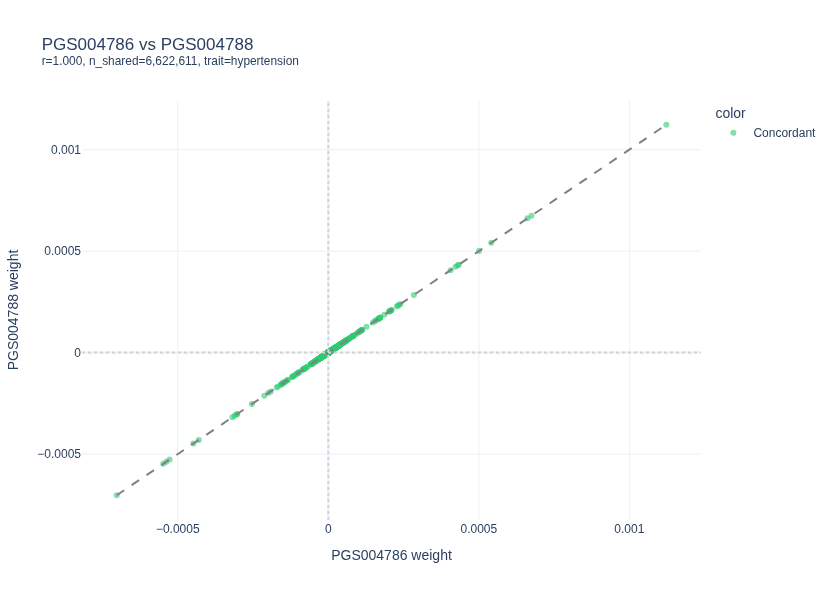

In [45]:
# Demo: Plot a pair from the sample
if comparison_stats is not None and shared_variants_dict:
    sample_keys = set(shared_variants_dict.keys())
    print(f"Looking for matches among {len(sample_keys)} sample pairs...")
    
    # Find any pair that exists in sample (sorted by correlation for a good example)
    found = False
    for _, row in comparison_stats.dropna(subset=['pearson_r']).sort_values('pearson_r', ascending=False).iterrows():
        key = f"{row['pgs_id_1']}_{row['pgs_id_2']}"
        alt_key = f"{row['pgs_id_2']}_{row['pgs_id_1']}"
        if key in sample_keys or alt_key in sample_keys:
            print(f"\nExample: {row['pgs_id_1']} vs {row['pgs_id_2']}")
            print(f"Trait: {row['trait_label']}")
            print(f"Correlation: r = {row['pearson_r']:.3f}")
            print(f"Shared variants: {row['n_shared']:,}")

            fig = plot_pgs_comparison(
                row["pgs_id_1"], row["pgs_id_2"],
                shared_variants_dict, comparison_stats
            )
            if fig:
                fig.show()
            found = True
            break
    
    if not found:
        print("No matching pairs found in sample!")
        print(f"Sample keys: {list(sample_keys)[:5]}")
elif not shared_variants_dict:
    print("⚠ No sample variants loaded")
    print("   Run: python scripts/extract_sample_variants.py")
else:
    print("⚠ comparison_stats not loaded")

---
## Output Files Summary

In [46]:
print("=" * 70)
print("OUTPUT FILES")
print("=" * 70)

total_size = 0
for f in sorted(OUTPUT_DIR.iterdir()):
    size_mb = f.stat().st_size / 1e6
    total_size += size_mb
    print(f"  {f.name}: {size_mb:.1f} MB")

print(f"\n  Total: {total_size:.1f} MB")

print("\n" + "=" * 70)
print("NEXT STEPS")
print("=" * 70)
print("""
1. Copy output files to the PGS Explorer app:
   cp pgs_comparison_data/output/* /path/to/pgs-catalog-explorer/data/

2. The Compare tab will automatically detect and load the data.

3. Files:
   - pgs_pairwise_stats.parquet: Main statistics table
   - pgs_pairwise_variants.json.gz: Variant data for scatterplots
   - trait_pairs_lookup.json: Quick trait -> pairs index
   - pipeline_metadata.json: Data provenance
   - qc_distributions.png: QC visualization
""")

print(f"\nPipeline completed: {datetime.now().isoformat()}")

OUTPUT FILES
  pgs_pairwise_stats.parquet: 5.0 MB
  pgs_pairwise_variants.json.gz: 4658.8 MB
  pipeline_metadata.json: 0.0 MB
  qc_distributions.png: 0.3 MB
  trait_pairs_lookup.json: 41.1 MB

  Total: 4705.2 MB

NEXT STEPS

1. Copy output files to the PGS Explorer app:
   cp pgs_comparison_data/output/* /path/to/pgs-catalog-explorer/data/

2. The Compare tab will automatically detect and load the data.

3. Files:
   - pgs_pairwise_stats.parquet: Main statistics table
   - pgs_pairwise_variants.json.gz: Variant data for scatterplots
   - trait_pairs_lookup.json: Quick trait -> pairs index
   - pipeline_metadata.json: Data provenance
   - qc_distributions.png: QC visualization


Pipeline completed: 2026-02-22T15:07:46.430264
